In [1]:
!unzip -q "testing390.zip" -d "testing390"


In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.5 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-qe92_iuu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-qe92_iuu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=b78ddc6802b2086e67f0a5b54f7b5c7cc869cf7fdcf51a43eaccc4a2652d868b
  Stored in directory: /tmp/pip-ephem-wheel-cache-nb9ectmv/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [3]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import cv2
import numpy as np

# Preprocessing function for images
def preprocess_image(image_path, input_size=224):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0)

# Feature extraction using DenseNet or ViT/CLIP
def extract_features(model, image_paths, model_type='densenet'):
    features = []
    for img_path in image_paths:
        input_tensor = preprocess_image(img_path)
        with torch.no_grad():
            if model_type == 'densenet':
                output = model.features(input_tensor)  # For DenseNet
                output = output.mean(dim=[2, 3])  # Global average pooling for DenseNet
            elif model_type == 'vit':
                output = model(input_tensor)  # For ViT
                output = output.mean(dim=1)  # Average over token embeddings
            features.append(output)
    return torch.cat(features, dim=0) if features else None

# Load pre-trained DenseNet and ViT/CLIP models
densenet = models.densenet121(pretrained=True).eval()
vit_model = models.vit_b_16(pretrained=True).eval()  # Using ViT from torchvision

# Calculate cosine similarity between two sets of features
def calculate_similarity(m_features, h_features):
    return F.cosine_similarity(m_features.unsqueeze(1), h_features.unsqueeze(0), dim=-1)

# Combine DenseNet and ViT features to compute similarity
def combine_similarity(m_images, h_images):
    m_features_densenet = extract_features(densenet, m_images, model_type='densenet')
    h_features_densenet = extract_features(densenet, h_images, model_type='densenet')

    m_features_vit = extract_features(vit_model, m_images, model_type='vit')
    h_features_vit = extract_features(vit_model, h_images, model_type='vit')

    if h_features_densenet is None:
        print("No valid h images for matching.")
        return None

    similarity_matrix_densenet = calculate_similarity(m_features_densenet, h_features_densenet) if m_features_densenet is not None else None
    similarity_matrix_vit = calculate_similarity(m_features_vit, h_features_vit) if m_features_vit is not None else None

    if similarity_matrix_densenet is not None and similarity_matrix_vit is not None:
        combined_similarity_matrix = (similarity_matrix_densenet + similarity_matrix_vit) / 2
    elif similarity_matrix_densenet is not None:
        combined_similarity_matrix = similarity_matrix_densenet
    elif similarity_matrix_vit is not None:
        combined_similarity_matrix = similarity_matrix_vit
    else:
        return None

    return combined_similarity_matrix

# Find best matching pairs based on similarity matrix
def find_best_matches(combined_similarity_matrix):
    if combined_similarity_matrix is not None:
        best_matches = torch.argmax(combined_similarity_matrix, dim=1)
        return best_matches
    else:
        return []

# Grad-CAM implementation for visualization
def generate_gradcam_heatmap(model, img_tensor, target_layer='features'):
    img_tensor.requires_grad = True
    output = model.features(img_tensor) if hasattr(model, 'features') else model(img_tensor)
    target = output[0]

    # Backpropagate to get gradients
    model.zero_grad()
    target.backward()

    # Get the gradients and target activations
    gradients = img_tensor.grad[0].cpu().numpy()
    activations = target.cpu().detach().numpy()

    # Pool the gradients over the spatial dimensions
    pooled_gradients = np.mean(gradients, axis=(1, 2))

    # Weight the activations by the pooled gradients
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    # Create a heatmap
    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negatives
    heatmap /= np.max(heatmap)  # Normalize
    return heatmap

# Function to overlay Grad-CAM heatmap on the original image
def overlay_heatmap_on_image(img_path, heatmap, intensity=0.4):
    image = cv2.imread(img_path)
    heatmap_resized = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    heatmap_resized = np.uint8(255 * heatmap_resized)
    heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

    # Combine heatmap with the original image
    overlayed_image = cv2.addWeighted(heatmap_color, intensity, image, 1 - intensity, 0)
    return overlayed_image

# Match and combine images
def match_images(h_images, m_images, s_images):
    # Determine the number of complete, partial, and unmatched sets
    num_complete_sets = min(len(h_images), len(m_images), len(s_images))
    num_partial_pairs = min(len(h_images), len(m_images)) - num_complete_sets

    complete_matches = []
    partial_pairs = []
    unmatched = []

    # Collect complete sets (h, m, s)
    for i in range(num_complete_sets):
        complete_matches.append((h_images[i], m_images[i], s_images[i]))

    # Collect partial sets (h, m)
    for i in range(num_complete_sets, num_complete_sets + num_partial_pairs):
        partial_pairs.append((h_images[i], m_images[i]))

    # Collect unmatched h files
    for i in range(num_complete_sets + num_partial_pairs, len(h_images)):
        unmatched.append(h_images[i])

    return complete_matches, partial_pairs, unmatched

# Main function to process patient folders
def process_patient_folders(parent_folder):
    # Iterate over all patient subfolders
    for patient_id in os.listdir(parent_folder):
        patient_folder = os.path.join(parent_folder, patient_id)
        if not os.path.isdir(patient_folder):
            continue

        # Gather h, m, and s files
        h_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('h')]
        m_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('m')]
        s_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('s')]

        if not h_images:
            print(f"Skipping patient {patient_id} due to missing h files.")
            continue

        # Step 1: Match images
        complete_matches, partial_pairs, unmatched = match_images(h_images, m_images, s_images)

        # Step 2: Process complete matches (h, m, s)
        for h_img, m_img, s_img in complete_matches:
            print(f"Complete match: {h_img}, {m_img}, {s_img}")
            # Process as needed (e.g., combine Grad-CAM visualizations)

        # Step 3: Process partial pairs (h, m)
        for h_img, m_img in partial_pairs:
            print(f"Partial pair: {h_img}, {m_img}")
            # Process as needed (e.g., combine Grad-CAM visualizations)

        # Step 4: Handle unmatched h files
        for h_img in unmatched:
            print(f"Unmatched h file: {h_img}")

# Example usage:
parent_folder = '/content/testing390/testing390'
process_patient_folders(parent_folder)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 125MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may 

Complete match: /content/testing390/testing390/55/h8.png, /content/testing390/testing390/55/m3.png, /content/testing390/testing390/55/s3.png
Partial pair: /content/testing390/testing390/55/h5.png, /content/testing390/testing390/55/m4.png
Unmatched h file: /content/testing390/testing390/55/h7.png
Unmatched h file: /content/testing390/testing390/55/h6.png
Complete match: /content/testing390/testing390/54/h9.png, /content/testing390/testing390/54/m5.png, /content/testing390/testing390/54/s2.png
Partial pair: /content/testing390/testing390/54/h12.png, /content/testing390/testing390/54/m6.png
Unmatched h file: /content/testing390/testing390/54/h10.png
Unmatched h file: /content/testing390/testing390/54/h11.png
Complete match: /content/testing390/testing390/53/h3.png, /content/testing390/testing390/53/m2.png, /content/testing390/testing390/53/s1.png
Partial pair: /content/testing390/testing390/53/h1.png, /content/testing390/testing390/53/m1.png
Unmatched h file: /content/testing390/testing39

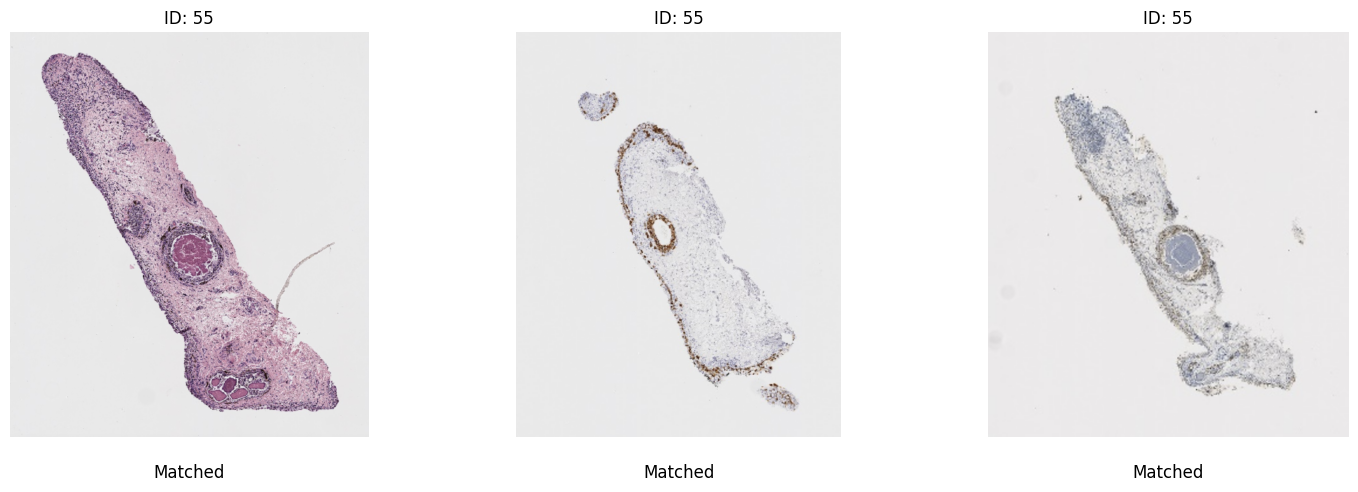

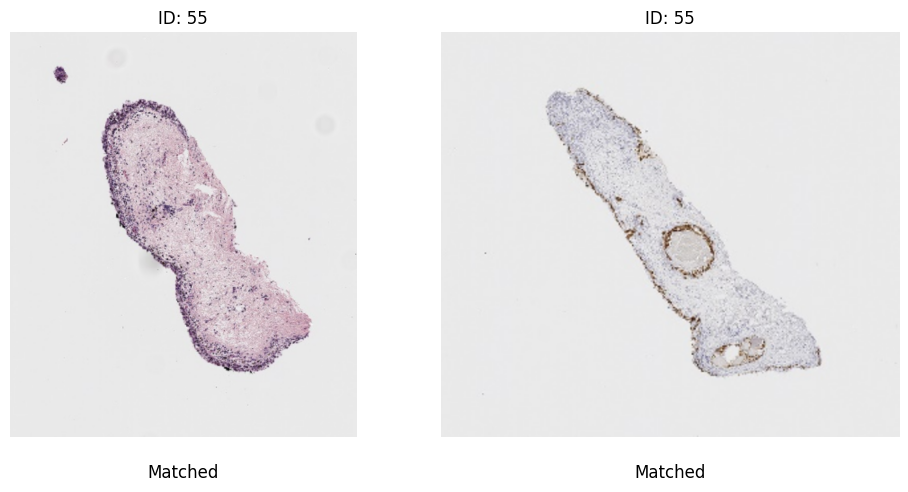

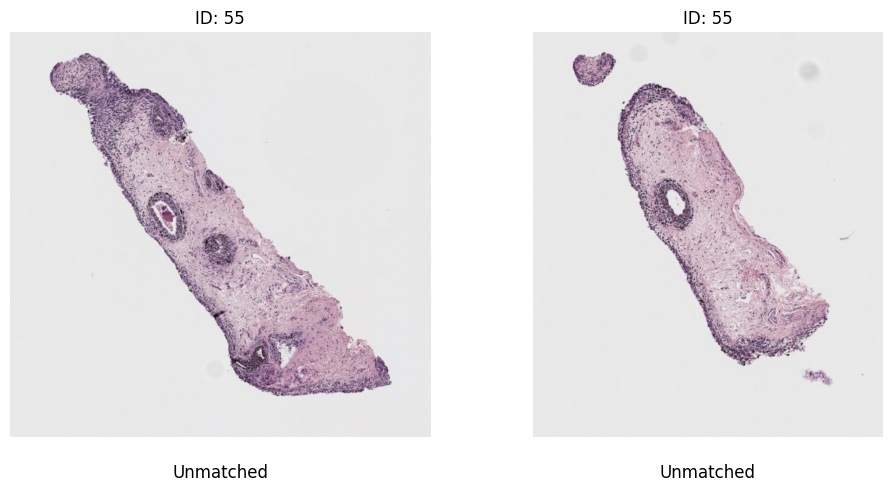

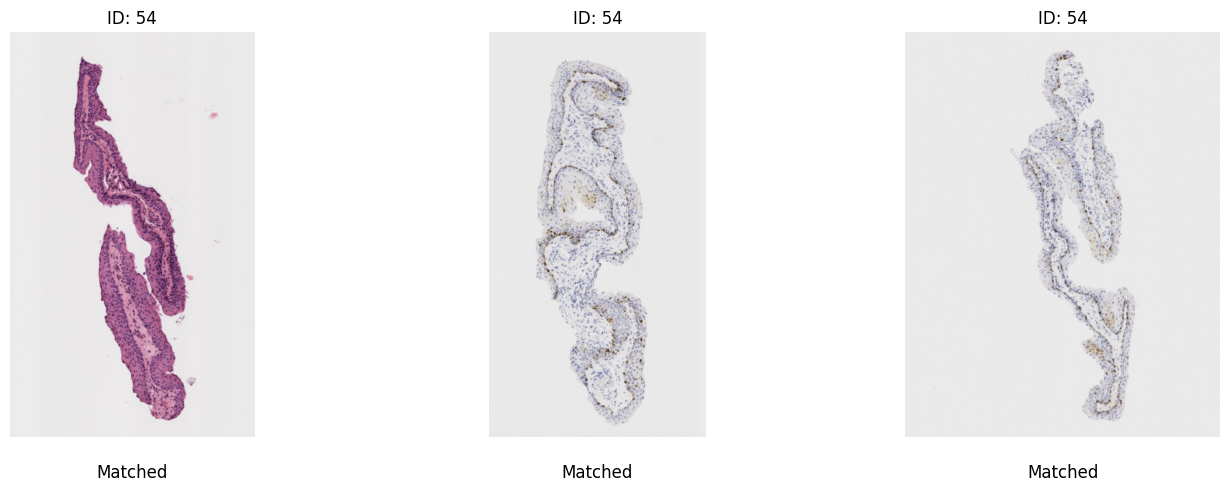

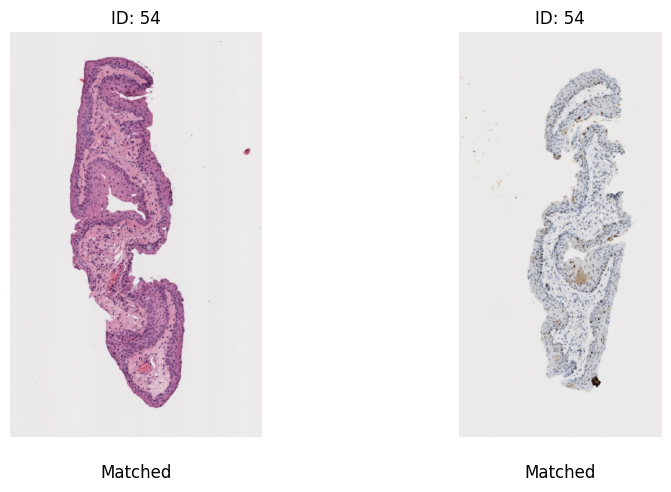

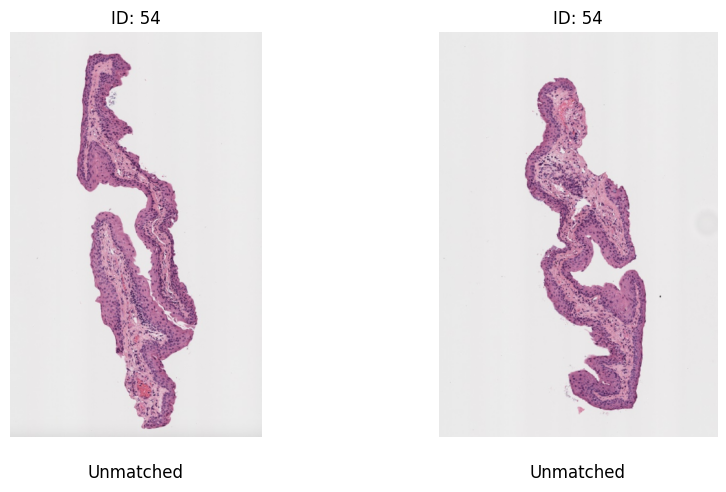

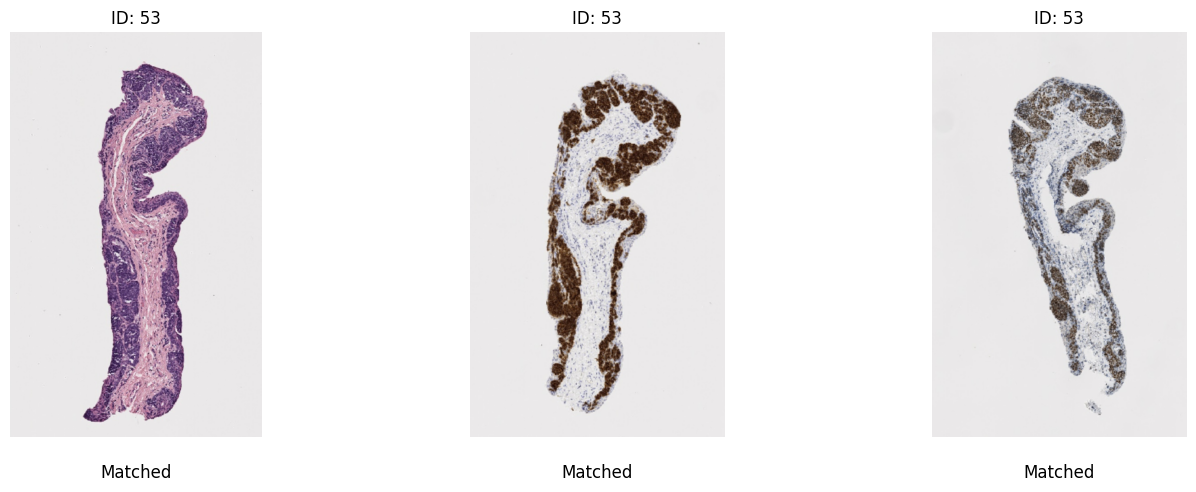

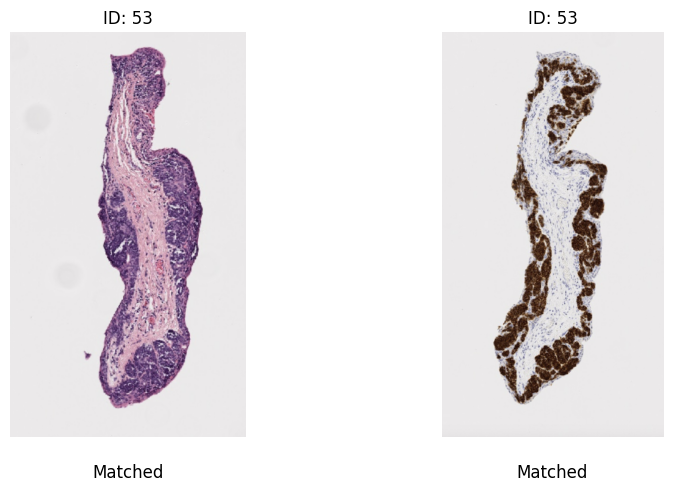

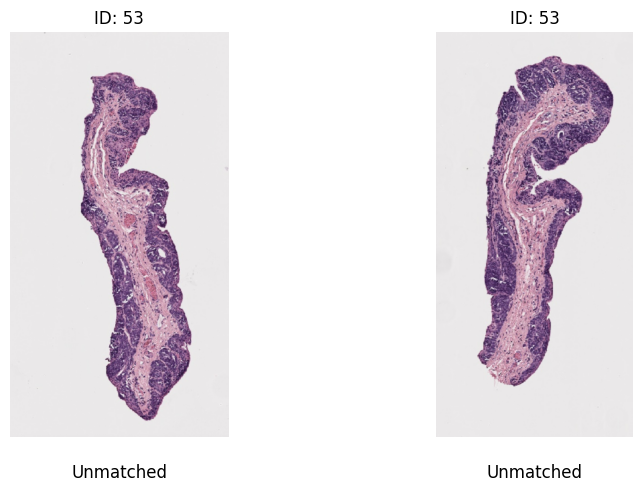

In [4]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Preprocessing function for images
def preprocess_image(image_path, input_size=224):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0)

# Feature extraction using DenseNet or ViT/CLIP
def extract_features(model, image_paths, model_type='densenet'):
    features = []
    for img_path in image_paths:
        input_tensor = preprocess_image(img_path)
        with torch.no_grad():
            if model_type == 'densenet':
                output = model.features(input_tensor)  # For DenseNet
                output = output.mean(dim=[2, 3])  # Global average pooling for DenseNet
            elif model_type == 'vit':
                output = model(input_tensor)  # For ViT
                output = output.mean(dim=1)  # Average over token embeddings
            features.append(output)
    return torch.cat(features, dim=0) if features else None

# Load pre-trained DenseNet and ViT/CLIP models
densenet = models.densenet121(pretrained=True).eval()
vit_model = models.vit_b_16(pretrained=True).eval()  # Using ViT from torchvision

# Calculate cosine similarity between two sets of features
def calculate_similarity(m_features, h_features):
    return F.cosine_similarity(m_features.unsqueeze(1), h_features.unsqueeze(0), dim=-1)

# Combine DenseNet and ViT features to compute similarity
def combine_similarity(m_images, h_images):
    m_features_densenet = extract_features(densenet, m_images, model_type='densenet')
    h_features_densenet = extract_features(densenet, h_images, model_type='densenet')

    m_features_vit = extract_features(vit_model, m_images, model_type='vit')
    h_features_vit = extract_features(vit_model, h_images, model_type='vit')

    if h_features_densenet is None:
        print("No valid h images for matching.")
        return None

    similarity_matrix_densenet = calculate_similarity(m_features_densenet, h_features_densenet) if m_features_densenet is not None else None
    similarity_matrix_vit = calculate_similarity(m_features_vit, h_features_vit) if m_features_vit is not None else None

    if similarity_matrix_densenet is not None and similarity_matrix_vit is not None:
        combined_similarity_matrix = (similarity_matrix_densenet + similarity_matrix_vit) / 2
    elif similarity_matrix_densenet is not None:
        combined_similarity_matrix = similarity_matrix_densenet
    elif similarity_matrix_vit is not None:
        combined_similarity_matrix = similarity_matrix_vit
    else:
        return None

    return combined_similarity_matrix

# Find best matching pairs based on similarity matrix
def find_best_matches(combined_similarity_matrix):
    if combined_similarity_matrix is not None:
        best_matches = torch.argmax(combined_similarity_matrix, dim=1)
        return best_matches
    else:
        return []

# Grad-CAM implementation for visualization
def generate_gradcam_heatmap(model, img_tensor, target_layer='features'):
    img_tensor.requires_grad = True
    output = model.features(img_tensor) if hasattr(model, 'features') else model(img_tensor)
    target = output[0]

    # Backpropagate to get gradients
    model.zero_grad()
    target.backward()

    # Get the gradients and target activations
    gradients = img_tensor.grad[0].cpu().numpy()
    activations = target.cpu().detach().numpy()

    # Pool the gradients over the spatial dimensions
    pooled_gradients = np.mean(gradients, axis=(1, 2))

    # Weight the activations by the pooled gradients
    for i in range(activations.shape[0]):
        activations[i, :, :] *= pooled_gradients[i]

    # Create a heatmap
    heatmap = np.mean(activations, axis=0)
    heatmap = np.maximum(heatmap, 0)  # ReLU to remove negatives
    heatmap /= np.max(heatmap)  # Normalize
    return heatmap

# Visualization function to display matches and unmatched images
def visualize_matches(patient_id, complete_matches, partial_pairs, unmatched_h, image_folder):
    # Visualize complete matched pairs (h, m, s)
    n_complete_pairs = len(complete_matches)
    if n_complete_pairs > 0:
        fig, axes = plt.subplots(n_complete_pairs, 3, figsize=(15, 5 * n_complete_pairs))
        if n_complete_pairs == 1:  # Ensure axes format is consistent for a single pair
            axes = [axes]

        for idx, (h_img, m_img, s_img) in enumerate(complete_matches):
            h_img_data = Image.open(os.path.join(image_folder, h_img))
            m_img_data = Image.open(os.path.join(image_folder, m_img))
            s_img_data = Image.open(os.path.join(image_folder, s_img))

            axes[idx][0].imshow(h_img_data)
            axes[idx][0].axis('off')
            axes[idx][0].set_title(f"ID: {patient_id}")
            axes[idx][0].text(0.5, -0.1, "Matched", size=12, ha="center", transform=axes[idx][0].transAxes)

            axes[idx][1].imshow(m_img_data)
            axes[idx][1].axis('off')
            axes[idx][1].set_title(f"ID: {patient_id}")
            axes[idx][1].text(0.5, -0.1, "Matched", size=12, ha="center", transform=axes[idx][1].transAxes)

            axes[idx][2].imshow(s_img_data)
            axes[idx][2].axis('off')
            axes[idx][2].set_title(f"ID: {patient_id}")
            axes[idx][2].text(0.5, -0.1, "Matched", size=12, ha="center", transform=axes[idx][2].transAxes)

        plt.tight_layout()
        plt.savefig(os.path.join(image_folder, f'{patient_id}_complete_matches.png'))
        plt.show()

    # Visualize partial pairs (h, m) or (h, s)
    n_partial_pairs = len(partial_pairs)
    if n_partial_pairs > 0:
        fig, axes = plt.subplots(n_partial_pairs, 2, figsize=(10, 5 * n_partial_pairs))
        if n_partial_pairs == 1:
            axes = [axes]

        for idx, pair in enumerate(partial_pairs):
            h_img = pair[0]  # Always have h_img
            h_img_data = Image.open(os.path.join(image_folder, h_img))

            axes[idx][0].imshow(h_img_data)
            axes[idx][0].axis('off')
            axes[idx][0].set_title(f"ID: {patient_id}")
            axes[idx][0].text(0.5, -0.1, "Matched", size=12, ha="center", transform=axes[idx][0].transAxes)

            # Handle either m_img or s_img
            if len(pair) == 2:
                other_img = pair[1]  # Can be m_img or s_img
                other_img_data = Image.open(os.path.join(image_folder, other_img))
                axes[idx][1].imshow(other_img_data)
                axes[idx][1].axis('off')
                axes[idx][1].set_title(f"ID: {patient_id}")
                axes[idx][1].text(0.5, -0.1, "Matched", size=12, ha="center", transform=axes[idx][1].transAxes)

        plt.tight_layout()
        plt.savefig(os.path.join(image_folder, f'{patient_id}_partial_matches.png'))
        plt.show()

    # Visualize unmatched h images
    if unmatched_h:
        fig, axes = plt.subplots(1, len(unmatched_h), figsize=(5 * len(unmatched_h), 5))
        if len(unmatched_h) == 1:
            axes = [axes]

        for idx, h_img in enumerate(unmatched_h):
            h_img_data = Image.open(os.path.join(image_folder, h_img))
            axes[idx].imshow(h_img_data)
            axes[idx].axis('off')
            axes[idx].set_title(f"ID: {patient_id}")
            axes[idx].text(0.5, -0.1, "Unmatched", size=12, ha="center", transform=axes[idx].transAxes)

        plt.tight_layout()
        plt.savefig(os.path.join(image_folder, f'{patient_id}_unmatched_h_images.png'))
        plt.show()

# Main function to process patient folders
def process_patient_folders(parent_folder):
    # Iterate over all patient subfolders
    for patient_id in os.listdir(parent_folder):
        patient_folder = os.path.join(parent_folder, patient_id)
        if not os.path.isdir(patient_folder):
            continue

        # Gather h, m, and s files
        h_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('h')]
        m_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('m')]
        s_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('s')]

        if not h_images:
            print(f"Skipping patient {patient_id} due to missing h files.")
            continue

        # Step 1: Match images
        complete_matches, partial_pairs, unmatched = match_images(h_images, m_images, s_images)

        # Step 2: Visualize and save the results
        visualize_matches(patient_id, complete_matches, partial_pairs, unmatched, patient_folder)

# Example usage:
parent_folder = '/content/testing390/testing390'
process_patient_folders(parent_folder)


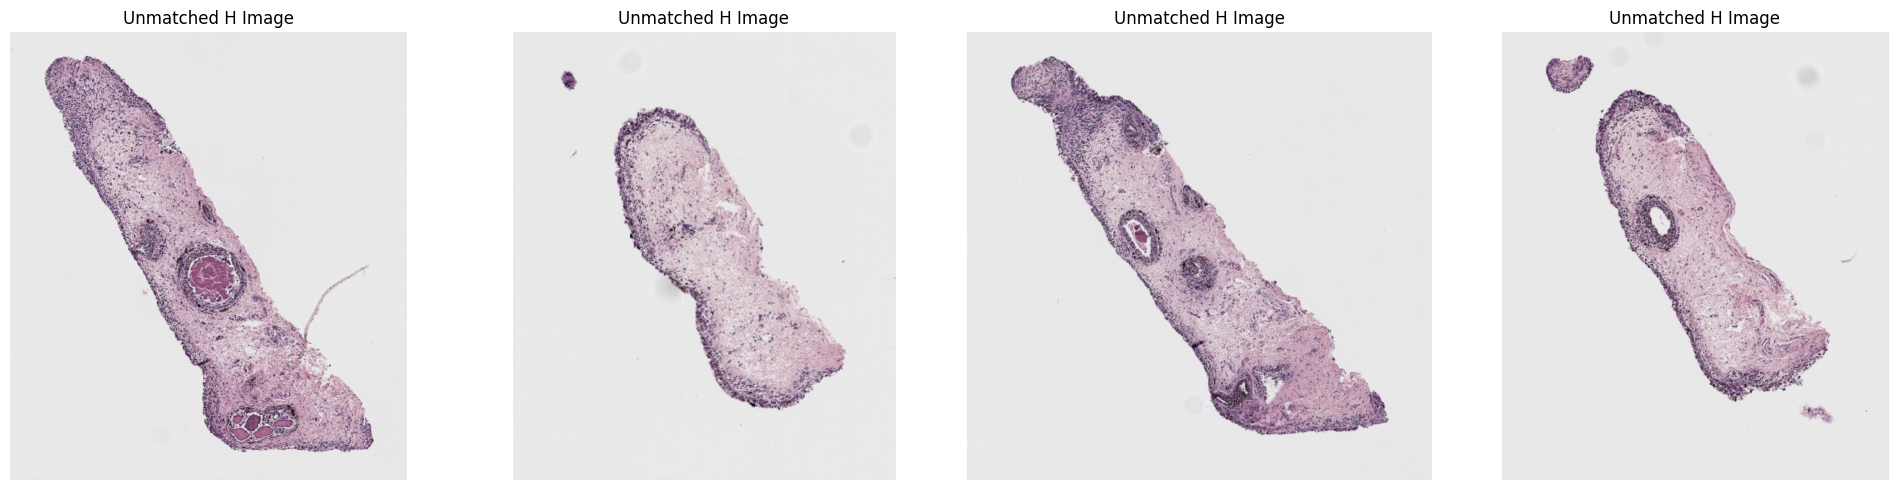

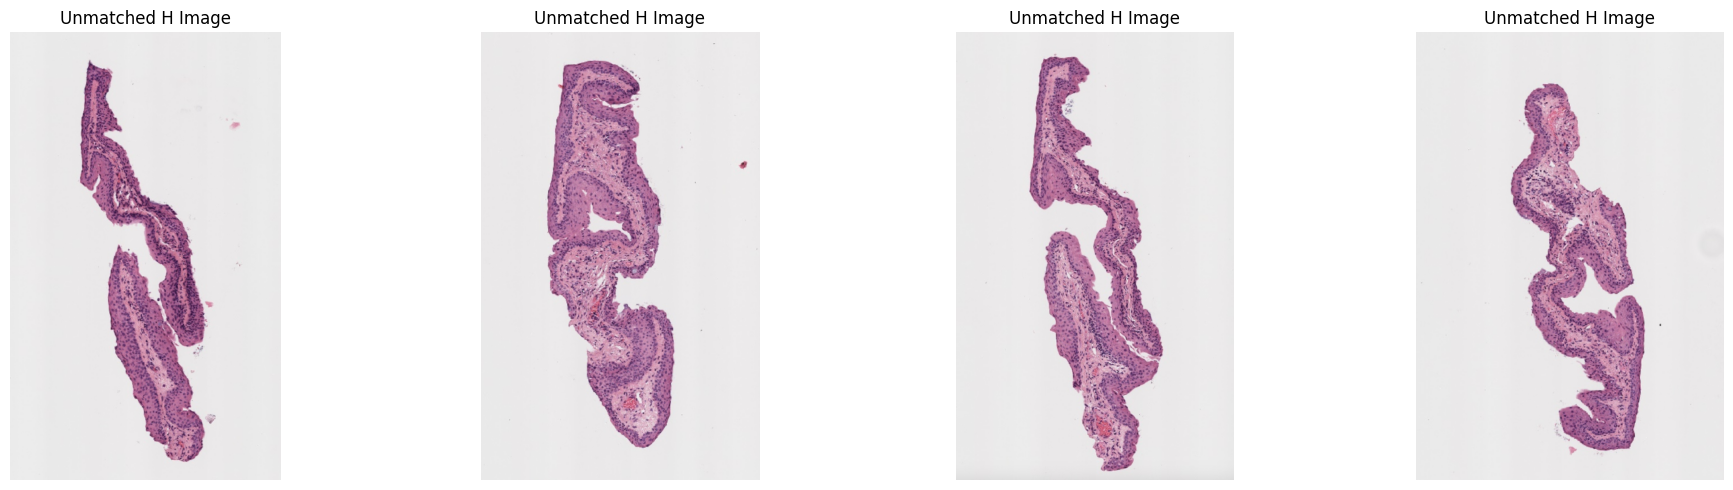

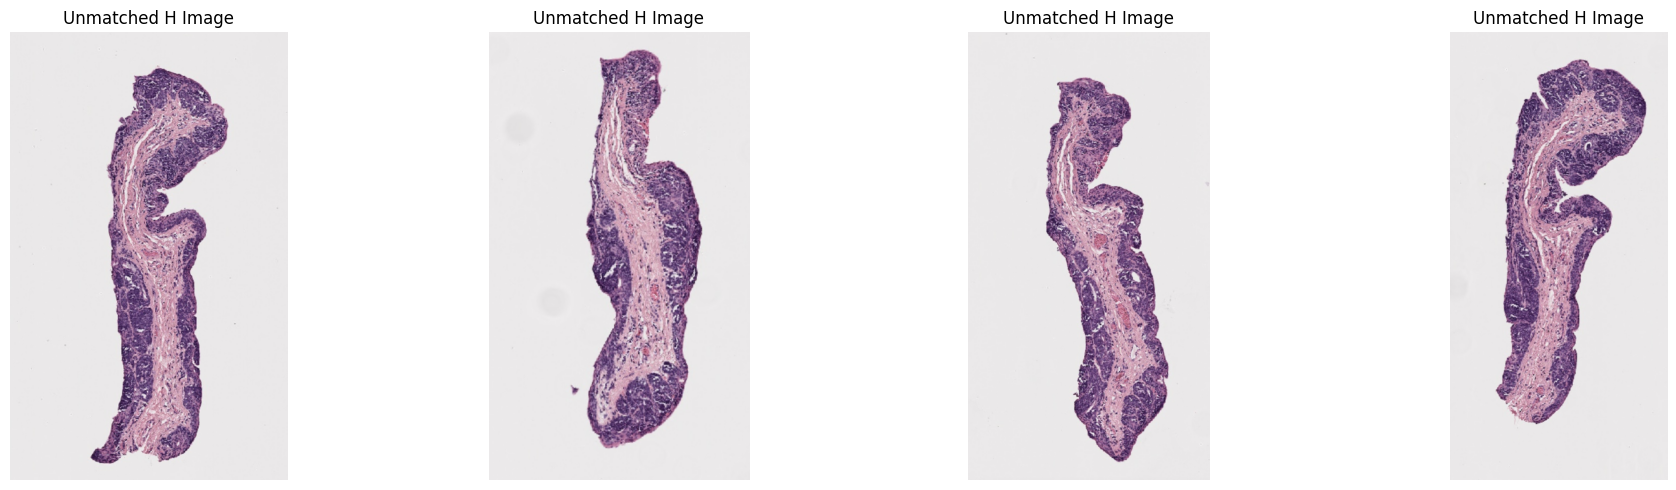

In [6]:
import os
import torch
import torch.nn.functional as F
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Preprocessing function for images
def preprocess_image(image_path, input_size=224):
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(image_path).convert("RGB")
    return preprocess(image).unsqueeze(0)

# Feature extraction function
def extract_features(model, image_paths, model_type='densenet'):
    features = []
    for img_path in image_paths:
        input_tensor = preprocess_image(img_path)
        with torch.no_grad():
            if model_type == 'densenet':
                output = model.features(input_tensor)
                output = output.mean(dim=[2, 3])  # Global average pooling for DenseNet
            elif model_type == 'vit':
                output = model(input_tensor)
                output = output.mean(dim=1)  # Average over token embeddings
            features.append(output)
    return torch.cat(features, dim=0) if features else None

# Load pre-trained models
densenet = models.densenet121(pretrained=True).eval()
vit_model = models.vit_b_16(pretrained=True).eval()

# Calculate cosine similarity between two sets of features
def calculate_similarity(m_features, h_features):
    return F.cosine_similarity(m_features.unsqueeze(1), h_features.unsqueeze(0), dim=-1)

# Combine DenseNet and ViT features to compute similarity
def combine_similarity(m_images, h_images):
    # Extract features for both models and ensure matched dimensions
    m_features_densenet = extract_features(densenet, m_images, model_type='densenet')
    h_features_densenet = extract_features(densenet, h_images, model_type='densenet')

    m_features_vit = extract_features(vit_model, m_images, model_type='vit')
    h_features_vit = extract_features(vit_model, h_images, model_type='vit')

    # Calculate similarity matrices only if dimensions match
    similarity_matrix_densenet = calculate_similarity(m_features_densenet, h_features_densenet) if m_features_densenet.size(0) == h_features_densenet.size(0) else None
    similarity_matrix_vit = calculate_similarity(m_features_vit, h_features_vit) if m_features_vit.size(0) == h_features_vit.size(0) else None

    # Combine matrices if both are available
    if similarity_matrix_densenet is not None and similarity_matrix_vit is not None:
        combined_similarity_matrix = (similarity_matrix_densenet + similarity_matrix_vit) / 2
    elif similarity_matrix_densenet is not None:
        combined_similarity_matrix = similarity_matrix_densenet
    elif similarity_matrix_vit is not None:
        combined_similarity_matrix = similarity_matrix_vit
    else:
        return None

    return combined_similarity_matrix

# Match images based on similarity scores
def match_images(h_images, m_images, s_images):
    complete_matches = []
    partial_pairs = []
    unmatched = h_images.copy()

    # Calculate similarity matrices
    similarity_matrix_hm = combine_similarity(h_images, m_images)
    similarity_matrix_hs = combine_similarity(h_images, s_images)

    # Match images based on highest similarity scores
    if similarity_matrix_hm is not None and similarity_matrix_hs is not None:
        for i, h_img in enumerate(h_images):
            m_match_idx = torch.argmax(similarity_matrix_hm[i]).item()
            s_match_idx = torch.argmax(similarity_matrix_hs[i]).item()
            complete_matches.append((h_img, m_images[m_match_idx], s_images[s_match_idx]))
            unmatched.remove(h_img)

    return complete_matches, partial_pairs, unmatched

# Visualization function for displaying results
def visualize_matches(patient_id, complete_matches, partial_pairs, unmatched_h, image_folder):
    # Display complete matches
    n_complete_pairs = len(complete_matches)
    if n_complete_pairs > 0:
        fig, axes = plt.subplots(n_complete_pairs, 3, figsize=(15, 5 * n_complete_pairs))
        if n_complete_pairs == 1:
            axes = [axes]

        for idx, (h_img, m_img, s_img) in enumerate(complete_matches):
            h_img_data = Image.open(os.path.join(image_folder, h_img))
            m_img_data = Image.open(os.path.join(image_folder, m_img))
            s_img_data = Image.open(os.path.join(image_folder, s_img))

            axes[idx][0].imshow(h_img_data)
            axes[idx][0].axis('off')
            axes[idx][0].set_title("Matched H Image")

            axes[idx][1].imshow(m_img_data)
            axes[idx][1].axis('off')
            axes[idx][1].set_title("Matched M Image")

            axes[idx][2].imshow(s_img_data)
            axes[idx][2].axis('off')
            axes[idx][2].set_title("Matched S Image")

        plt.tight_layout()
        plt.show()

    # Display unmatched images
    if unmatched_h:
        fig, axes = plt.subplots(1, len(unmatched_h), figsize=(5 * len(unmatched_h), 5))
        if len(unmatched_h) == 1:
            axes = [axes]

        for idx, h_img in enumerate(unmatched_h):
            h_img_data = Image.open(os.path.join(image_folder, h_img))
            axes[idx].imshow(h_img_data)
            axes[idx].axis('off')
            axes[idx].set_title("Unmatched H Image")

        plt.tight_layout()
        plt.show()

# Main function to process patient folders
def process_patient_folders(parent_folder):
    for patient_id in os.listdir(parent_folder):
        patient_folder = os.path.join(parent_folder, patient_id)
        if not os.path.isdir(patient_folder):
            continue

        # Gather h, m, and s files
        h_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('h')]
        m_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('m')]
        s_images = [os.path.join(patient_folder, f) for f in os.listdir(patient_folder) if f.startswith('s')]

        if not h_images:
            print(f"Skipping patient {patient_id} due to missing h files.")
            continue

        # Step 1: Match images based on similarity
        complete_matches, partial_pairs, unmatched = match_images(h_images, m_images, s_images)

        # Step 2: Visualize the results
        visualize_matches(patient_id, complete_matches, partial_pairs, unmatched, patient_folder)

# Example usage
parent_folder = '/content/testing390/testing390'
process_patient_folders(parent_folder)
